In [1]:
import numpy as np
from astropy.io import fits
import astropy.units as u
from IPython.display import clear_output
from pathlib import Path
from importlib import reload
import time
import os

import cupy as cp

import poppy
from poppy.poppy_core import PlaneType

import misc

# set debugging mode for more information from POPPY as propagation is performed
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = False

wavelength = 500e-9*u.m

# Arbitrary Fraunhofer Demo

In [2]:
npix = 256
oversample = 4
npsf = 256

INFO:poppy:Initialized OpticalSystem: unnamed system
INFO:poppy:Added pupil plane: unnamed
INFO:poppy:Added image plane: -empty-
INFO:poppy:Added pupil plane: Zernike WFE
INFO:poppy:Added detector with pixelscale=0.02 and oversampling=4: Detector
INFO:poppy:Calculating PSF with 1 wavelengths
DEBUG:poppy:Trying to reload wisdom from file /home/u21/kianmilani/.astropy/config/poppy_fftw_wisdom.json
DEBUG:poppy:Reloaded double precision wisdom: True
DEBUG:poppy:Reloaded single precision wisdom: True
DEBUG:poppy:Reloaded longdouble precision wisdom: True
DEBUG:poppy:Reloaded _FFTW_INIT list of optimized array sizes 
INFO:poppy: Propagating wavelength = 5e-07 m
DEBUG:poppy:Input wavefront has wavelength=5e-07 m, npix=256, diam=2.4, pixel scale=0.00937 meters/pixel
DEBUG:poppy:  Wavefront and optic unnamed already at same plane type, no propagation needed.
DEBUG:poppy:  Multiplied WF by phasor for Pupil plane: unnamed
DEBUG:poppy:normalizing at first plane (entrance pupil) to 1.0 total intens

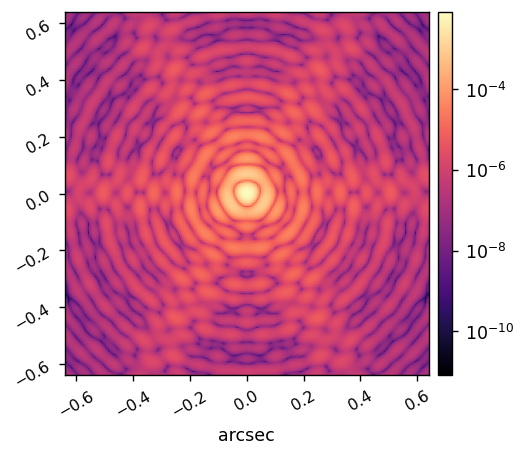

In [3]:
poppy.conf.use_cupy = False

diam = 2.4*u.m

circ_pupil = poppy.CircularAperture(radius=diam/2)
asym_sec_obs = poppy.AsymmetricSecondaryObscuration(secondary_radius=diam/5, support_angle=(60, 180, 300), 
                                                    support_width=0.1*u.m, support_offset_x=0.0, support_offset_y=0.0,)
compound_pupil = poppy.CompoundAnalyticOptic(opticslist=[circ_pupil, asym_sec_obs])

scalar_trans_image = poppy.ScalarTransmission(planetype=PlaneType.image)
zern_wfe = poppy.ZernikeWFE(coefficients=[0,0,0,0,0,0,0,0,wavelength.value/40], radius=diam/2, aperture_stop=True)

osys = poppy.OpticalSystem(pupil_diameter=diam, npix=npix, oversample=oversample)

osys.add_pupil(compound_pupil)
osys.add_image(scalar_trans_image)
osys.add_pupil(zern_wfe)
osys.add_detector(pixelscale=0.020, fov_arcsec=4.0)

psf_cpu = osys.calc_psf(wavelength=wavelength,)
misc.myimshow(psf_cpu[0].data, npix=npsf, pxscl=psf_cpu[0].header['PIXELSCL']*u.arcsec/u.pix, lognorm=True,)

INFO:poppy:Initialized OpticalSystem: unnamed system
INFO:poppy:Added pupil plane: unnamed
INFO:poppy:Added image plane: -empty-
INFO:poppy:Added pupil plane: Zernike WFE
INFO:poppy:Added detector with pixelscale=0.02 and oversampling=4: Detector
INFO:poppy:Calculating PSF with 1 wavelengths
DEBUG:poppy:Already loaded wisdom prior to this calculation, not reloading.
INFO:poppy: Propagating wavelength = 5e-07 m
DEBUG:poppy:Input wavefront has wavelength=5e-07 m, npix=256, diam=2.4, pixel scale=0.00937 meters/pixel
DEBUG:poppy:  Wavefront and optic unnamed already at same plane type, no propagation needed.
DEBUG:poppy:  Multiplied WF by phasor for Pupil plane: unnamed
DEBUG:poppy:normalizing at first plane (entrance pupil) to 1.0 total intensity
DEBUG:poppy:  Propagating wavefront to Image plane: -empty-. 
DEBUG:poppy:    Padded WF array for oversampling by 4x
DEBUG:poppy:using cupy (GPU) FFT of (1024, 1024) array, FFT_direction=backward
DEBUG:poppy:    FFT_2D: FFT in 0.023360 s, full fu

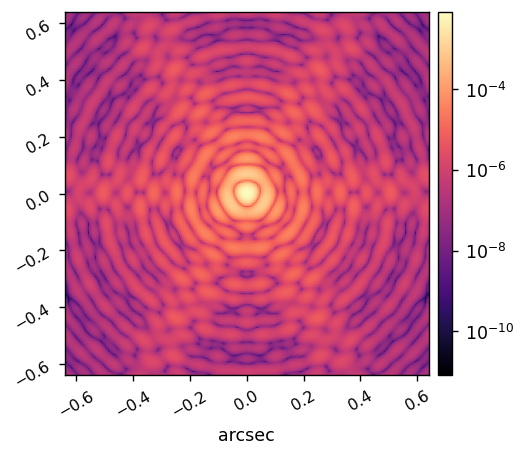

In [4]:
poppy.conf.use_cupy = True

diam = 2.4*u.m
circ_pupil = poppy.CircularAperture(radius=diam/2)
asym_sec_obs = poppy.AsymmetricSecondaryObscuration(secondary_radius=diam/5, support_angle=(60, 180, 300), 
                                                    support_width=0.1*u.m, support_offset_x=0.0, support_offset_y=0.0,)
compound_pupil = poppy.CompoundAnalyticOptic(opticslist=[circ_pupil, asym_sec_obs])

scalar_trans_image = poppy.ScalarTransmission(planetype=PlaneType.image)
zern_wfe = poppy.ZernikeWFE(coefficients=[0,0,0,0,0,0,0,0,wavelength.value/40], radius=diam/2, aperture_stop=True)

osys = poppy.OpticalSystem(pupil_diameter=diam, npix=npix, oversample=oversample)

# osys.add_pupil(multi_circ_pupil)
osys.add_pupil(compound_pupil)
osys.add_image(scalar_trans_image)
osys.add_pupil(zern_wfe)
osys.add_detector(pixelscale=0.020, fov_arcsec=4.0)

psf_gpu = osys.calc_psf(wavelength=wavelength,)
misc.myimshow(psf_gpu[0].data, npix=npsf, pxscl=psf_gpu[0].header['PIXELSCL']*u.arcsec/u.pix, lognorm=True,)

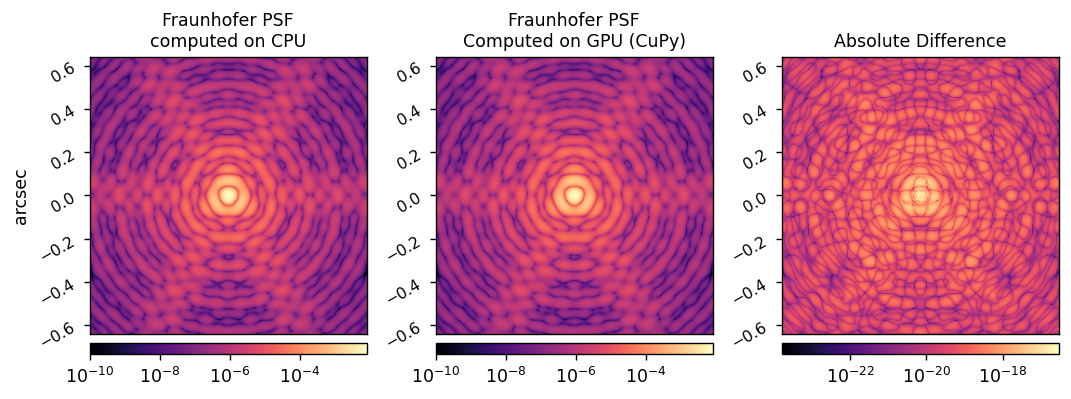

In [6]:
vmin = 1e-10

reload(misc)
misc.myimshow3(psf_cpu[0].data, psf_gpu[0].data, np.abs( psf_cpu[0].data - psf_gpu[0].data ),
               'Fraunhofer PSF\ncomputed on CPU', 'Fraunhofer PSF\nComputed on GPU (CuPy)', 'Absolute Difference', titlesize=10,
               npix=256,
               pxscl1=psf_cpu[0].header['PIXELSCL']*u.arcsec/u.pix, 
               pxscl2=psf_gpu[0].header['PIXELSCL']*u.arcsec/u.pix,
               pxscl3=psf_gpu[0].header['PIXELSCL']*u.arcsec/u.pix,
               use_ylabel2=False, use_ylabel3=False,
               lognorm1=True, lognorm2=True, lognorm3=True, 
               vmin1=vmin, vmin2=vmin)

# HST Fresnel Demo

In [2]:
npix = 256
oversample = 8

INFO:poppy:Initialized OpticalSystem: unnamed system
DEBUG:poppy:Initialized: Primary, fl =5.52e+00 m
DEBUG:poppy:Initialized: Secondary, fl =-6.79e-01 m
INFO:poppy:Added optic: Circle, radius=1.2 m after separation: 0.00e+00 m 
INFO:poppy:Added optic: Secondary Obscuration with 4 supports after separation: 0.00e+00 m 
INFO:poppy:Added optic: Primary after separation: 0.00e+00 m 
INFO:poppy:Added optic: Secondary after separation: 4.91e+00 m 
INFO:poppy:Added optic: focus after separation: 6.39e+00 m 
INFO:poppy:Calculating PSF with 1 wavelengths
DEBUG:poppy:Trying to reload wisdom from file /home/u21/kianmilani/.astropy/config/poppy_fftw_wisdom.json
DEBUG:poppy:Reloaded double precision wisdom: True
DEBUG:poppy:Reloaded single precision wisdom: True
DEBUG:poppy:Reloaded longdouble precision wisdom: True
DEBUG:poppy:Reloaded _FFTW_INIT list of optimized array sizes 
INFO:poppy: Propagating wavelength = 5e-07 m
DEBUG:poppy:Padded WF array for oversampling by 8.000, to (2048, 2048).
DEBU

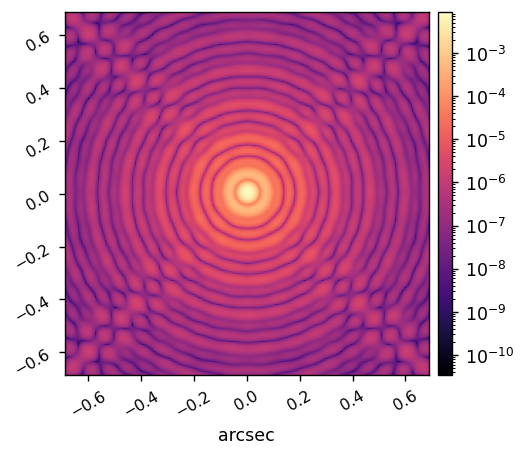

In [3]:
# HST example - Following example in PROPER Manual V2.0 page 49.
poppy.conf.use_cupy = False

diam = 2.4 * u.m
fl_pri = 5.52085 * u.m
d_pri_sec = 4.907028205 * u.m
fl_sec = -0.6790325 * u.m
d_sec_to_focus = 6.3919974 * u.m

hst = poppy.FresnelOpticalSystem(pupil_diameter=2.4*u.m, npix=npix, beam_ratio=1/oversample)
m1 = poppy.QuadraticLens(fl_pri, name='Primary')
m2 = poppy.QuadraticLens(fl_sec, name='Secondary')

hst.add_optic(poppy.CircularAperture(radius=diam.value/2))
hst.add_optic(poppy.SecondaryObscuration(secondary_radius=0.396,
                                 support_width=0.0264,
                                 support_angle_offset=45.0))
hst.add_optic(m1)
hst.add_optic(m2, distance=d_pri_sec)
hst.add_optic(poppy.ScalarTransmission(planetype=PlaneType.image, name='focus'), distance=d_sec_to_focus)

psf_cpu = hst.calc_psf(wavelength=wavelength)
misc.myimshow(psf_cpu[0].data, npix=npix, pxscl=psf_cpu[0].header['PIXELSCL']*u.arcsec/u.pix, lognorm=True,)

INFO:poppy:Initialized OpticalSystem: unnamed system
DEBUG:poppy:Initialized: Primary, fl =5.52e+00 m
DEBUG:poppy:Initialized: Secondary, fl =-6.79e-01 m
INFO:poppy:Added optic: Circle, radius=1.2 m after separation: 0.00e+00 m 
INFO:poppy:Added optic: Secondary Obscuration with 4 supports after separation: 0.00e+00 m 
INFO:poppy:Added optic: Primary after separation: 0.00e+00 m 
INFO:poppy:Added optic: Secondary after separation: 4.91e+00 m 
INFO:poppy:Added optic: focus after separation: 6.39e+00 m 
INFO:poppy:Calculating PSF with 1 wavelengths
DEBUG:poppy:Already loaded wisdom prior to this calculation, not reloading.
INFO:poppy: Propagating wavelength = 5e-07 m
DEBUG:poppy:Padded WF array for oversampling by 8.000, to (2048, 2048).
DEBUG:poppy:Input wavefront has wavelength=0.5 microns, npix=256, diam=2.4 m, pixel scale=0.009375 m / pix
DEBUG:poppy:  Propagating wavefront to Optic: Circle, radius=1.2 m after distance 0.0 m 
DEBUG:poppy:  Multiplied WF by phasor for Optic: Circle, r

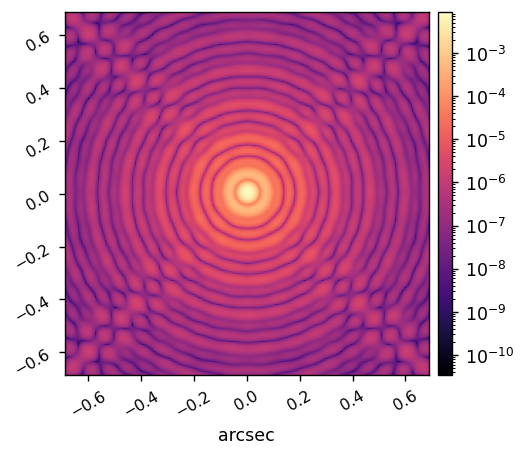

In [5]:
# HST example - Following example in PROPER Manual V2.0 page 49.
poppy.conf.use_cupy = True

diam = 2.4 * u.m
fl_pri = 5.52085 * u.m
d_pri_sec = 4.907028205 * u.m
fl_sec = -0.6790325 * u.m
d_sec_to_focus = 6.3919974 * u.m

hst = poppy.FresnelOpticalSystem(pupil_diameter=2.4*u.m, npix=npix, beam_ratio=1/oversample)
m1 = poppy.QuadraticLens(fl_pri, name='Primary')
m2 = poppy.QuadraticLens(fl_sec, name='Secondary')

hst.add_optic(poppy.CircularAperture(radius=diam.value/2))
hst.add_optic(poppy.SecondaryObscuration(secondary_radius=0.396,
                                 support_width=0.0264,
                                 support_angle_offset=45.0))
hst.add_optic(m1)
hst.add_optic(m2, distance=d_pri_sec)
hst.add_optic(poppy.ScalarTransmission(planetype=PlaneType.image, name='focus'), distance=d_sec_to_focus)

psf_gpu = hst.calc_psf(wavelength=wavelength)
misc.myimshow(psf_gpu[0].data, npix=256, pxscl=psf_gpu[0].header['PIXELSCL']*u.arcsec/u.pix, lognorm=True,)

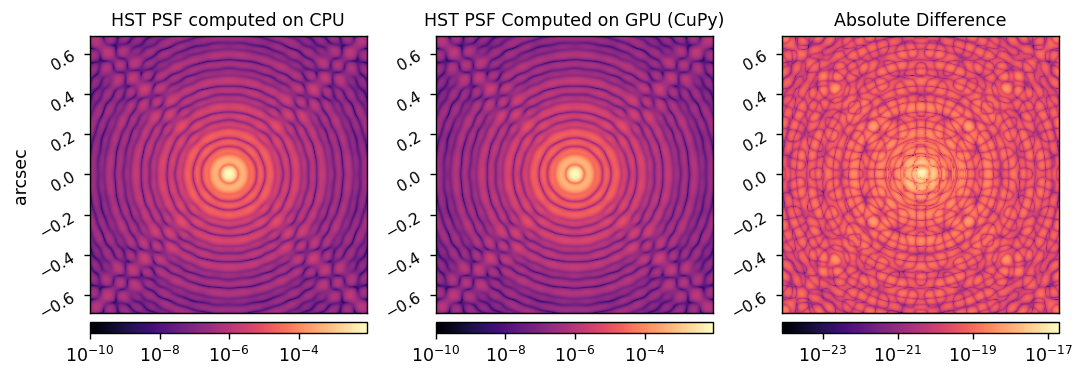

In [6]:
vmin = 1e-10

reload(misc)
misc.myimshow3(psf_cpu[0].data, psf_gpu[0].data, np.abs( psf_cpu[0].data - psf_gpu[0].data ),
               'HST PSF computed on CPU', 'HST PSF Computed on GPU (CuPy)', 'Absolute Difference', titlesize=10,
               npix=256,
               pxscl1=psf_cpu[0].header['PIXELSCL']*u.arcsec/u.pix, 
               pxscl2=psf_gpu[0].header['PIXELSCL']*u.arcsec/u.pix,
               pxscl3=psf_gpu[0].header['PIXELSCL']*u.arcsec/u.pix,
               lognorm1=True, lognorm2=True, lognorm3=True, 
               vmin1=vmin, vmin2=vmin)